In [1]:
import os, re
import numpy as np


# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi'] = 150

In [2]:
# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print(
        "[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository."
    )

In [3]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection

# The module to read spectrum, which also helps us to download the file (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec, read_spec_dr14q

# Sampling from CDDFs


In [4]:
# DLA CDDF: Prochaska & Wolfe 2009
# broken power law
# for log(N_HI) < 21.75: beta = -1.8
# for log(N_HI) > 21.75: beta = -3
log_nd = 21.75
log_k_dla = np.log10(7) - 25
log_cddf_dla = lambda log_n, beta_dla: log_k_dla + beta_dla * (log_n - log_nd)

# pivot point for SLLS
log_cddf_dla(20.3, -1.8)

# Super Lyman Limit Systems (SLLS) CDDF
# for 19 < log(N_HI) < 20.3: beta = -1.2
log_k_slls = log_cddf_dla(20.3, -1.8) + 1.2 * 20.3
log_cddf_slls = lambda log_n: log_k_slls - 1.2 * log_n

# Lyman Limit Systems (LLS) CDDF
# for 17.5 < log(N_HI) < 19: beta = -0.8
log_k_lls = log_cddf_slls(19) + 0.8 * 19
log_cddf_lls = lambda log_n: log_k_lls - 0.8 * log_n

In [5]:
# MgII CDDF: Churchill et al. 2020
# for 12 < log(N_MgII) < 15: beta = -1.45
# doppler parameter b = 5.7 km/s
log_k_mgii = (
    -12 + 1.45 * 14
)  # TODO: This is approximate value, need to send email ask Churchill
log_cddf_mgii = lambda log_n: log_k_mgii - 1.45 * log_n

# CIV CDDF: Kim et al. 2003
# for 12 < log(N_CIV) < 15: beta = -1.85
log_k_civ = 11.41
log_cddf_civ = lambda log_n: log_k_civ - 1.85 * log_n

## Visualizations


(17.5, 21.0)

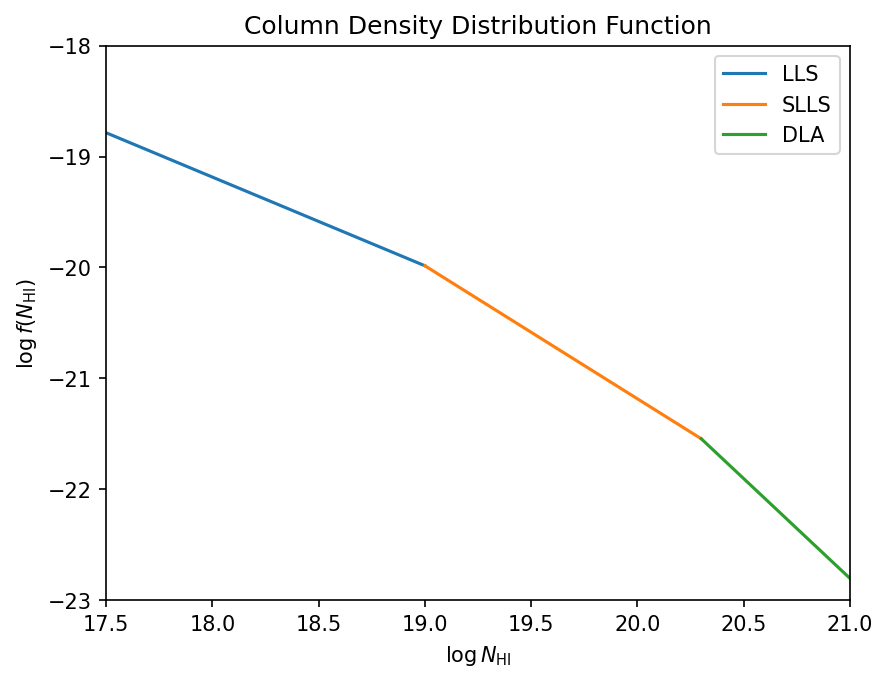

In [6]:
# Plot the CDDF
# Plot the LLS first
log_ns = np.linspace(17.5, 19, 100)
log_cddfs = log_cddf_lls(log_ns)
plt.plot(log_ns, log_cddfs, label="LLS", color="C0")
# Plot the SLLS
log_ns = np.linspace(19, 20.3, 100)
log_cddfs = log_cddf_slls(log_ns)
plt.plot(log_ns, log_cddfs, label="SLLS", color="C1")
# Plot the DLA
log_ns = np.linspace(20.3, 21.75, 100)
log_cddfs = log_cddf_dla(log_ns, -1.8)
plt.plot(log_ns, log_cddfs, label="DLA", color="C2")
log_ns = np.linspace(21.75, 23, 100)
log_cddfs = log_cddf_dla(log_ns, -3)
plt.plot(log_ns, log_cddfs, color="C2", linestyle="--")

# Add labels
plt.xlabel(r"$\log N_{\rm HI}$")
plt.ylabel(r"$\log f(N_{\rm HI})$")
plt.legend()
plt.title("Column Density Distribution Function")
plt.ylim(-23, -18)
plt.xlim(17.5, 21)

(12.0, 15.0)

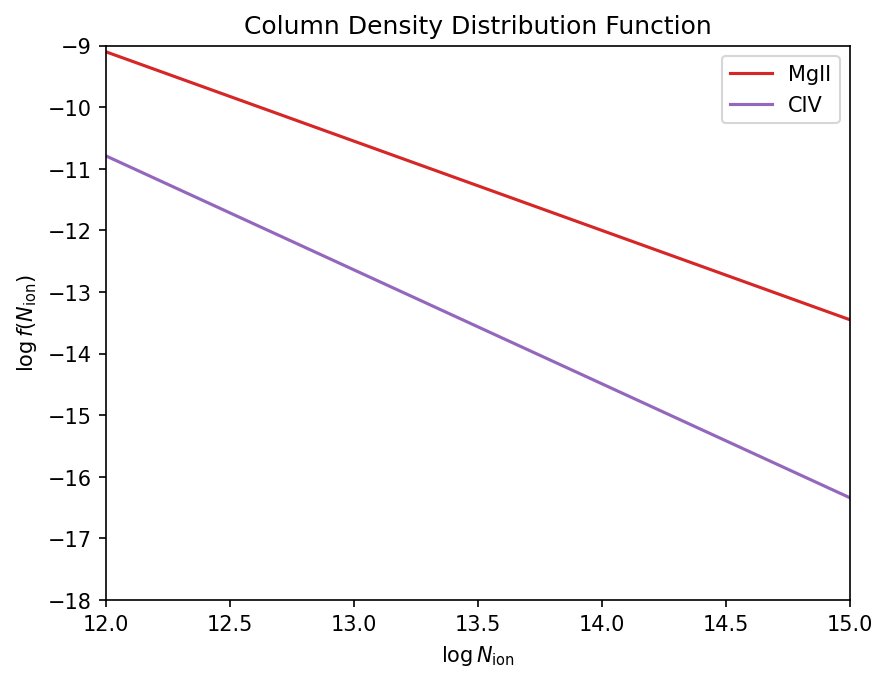

In [7]:
# Visualize the MgII and CIV CDDF
log_ns = np.linspace(12, 15, 100)
log_cddfs = log_cddf_mgii(log_ns)
plt.plot(log_ns, log_cddfs, label="MgII", color="C3")
log_cddfs = log_cddf_civ(log_ns)
plt.plot(log_ns, log_cddfs, label="CIV", color="C4")

plt.legend()
# Labels
plt.xlabel(r"$\log N_{\rm ion}$")
plt.ylabel(r"$\log f(N_{\rm ion})$")
plt.title("Column Density Distribution Function")
plt.ylim(-18, -9)
plt.xlim(12, 15)

## Generate samples


In [8]:
from scipy.integrate import (
    quad,
)  # to get the normalization constant for the probability density function

Sum of the PDF:


1.005083536765714

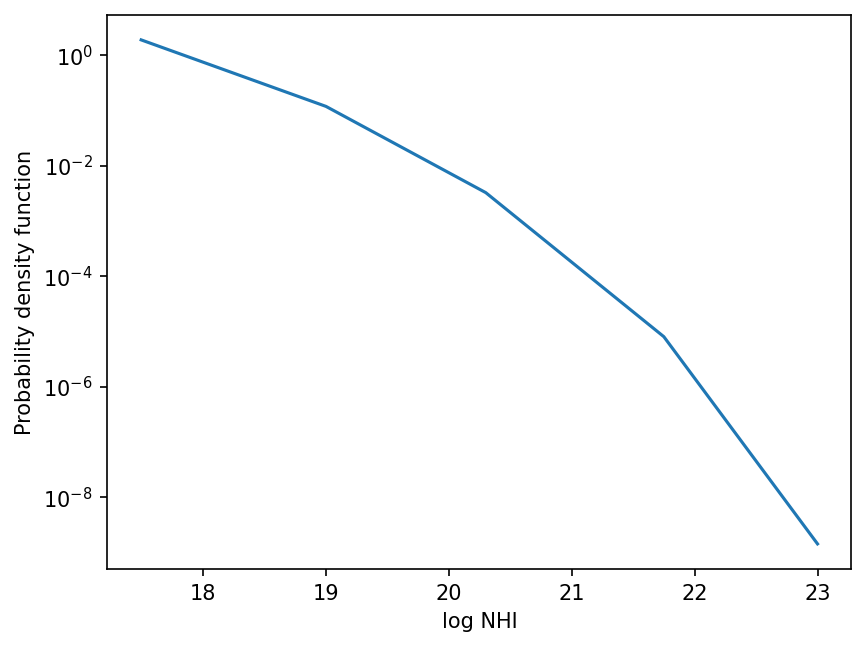

In [9]:
# directly CDDF for DLA, SLLS, LLS
unnormalized_pdf = lambda log_nhi: (
    10 ** log_cddf_lls(log_nhi) * (log_nhi < 19) * (log_nhi >= 17.5)
    + 10 ** log_cddf_slls(log_nhi) * (log_nhi >= 19) * (log_nhi < 20.3)
    + 10 ** log_cddf_dla(log_nhi, -1.8) * (log_nhi < 21.75) * (log_nhi >= 20.3)
    + 10 ** log_cddf_dla(log_nhi, -3) * (log_nhi >= 21.75)
)

Z = quad(unnormalized_pdf, 17.5, 23.0)[0]

normalized_pdf = lambda log_nhi: unnormalized_pdf(log_nhi) / Z

log_nhis = np.linspace(17.5, 23, num=1000)
plt.semilogy(log_nhis, normalized_pdf(log_nhis))
plt.xlabel("log NHI")
plt.ylabel("Probability density function")

# Make sure the probability density is summed to one
print("Sum of the PDF:")
np.sum(normalized_pdf(log_nhis) * (log_nhis[1] - log_nhis[0]))

Quasi Monte Carlo samples


In [10]:
# We want Monte Carlo samples - here to use Halton sequence to speed up the convergence
from scipy.stats.qmc import Halton
from scipy.interpolate import interp1d

sampler = Halton(
    d=2,  # dimension of parameter space
    scramble=False,
)

Inverse transform sampling


In [11]:
def inverse_transform_sampling(pdf, domain, sampler, num_samples, resolution=10000):
    """
    Generates samples from a given probability density function (pdf) using the inverse transform sampling method.

    Parameters:
    - pdf: A callable representing the probability density function.
    - domain: A tuple (min, max) specifying the range over which the pdf is defined.
    - n_samples: The number of samples to generate.
    - resolution: The number of points to use for approximating the inverse CDF.

    Returns:
    - samples: A NumPy array of samples generated from the pdf.
    """

    # Validate inputs
    if domain[0] >= domain[1]:
        raise ValueError(
            "Invalid domain. Ensure that the domain min is less than the domain max."
        )

    # Generate points within the domain and compute the PDF
    x = np.linspace(domain[0], domain[1], num=resolution)
    y = pdf(x)

    if np.any(y < 0):
        raise ValueError("PDF values must be non-negative.")

    # Compute the cumulative distribution function (CDF) and normalize
    cdf_y = np.cumsum(y)
    cdf_y = cdf_y / cdf_y[-1]  # Normalize to 1

    # Create the inverse CDF through interpolation
    inverse_cdf = interp1d(
        cdf_y, x, bounds_error=False, fill_value=(domain[0], domain[1])
    )

    # Generate uniform samples in the CDF range and convert to samples from the PDF
    halton_sequence = sampler.random(num_samples)

    samples = inverse_cdf(halton_sequence[:, 0])

    return samples

In [12]:
# Inverse transform sampling the CDDF of DLA, SLLS, LLS
samples = inverse_transform_sampling(normalized_pdf, (17.5, 23), sampler, 100000)

Text(0, 0.5, 'Probability density function')

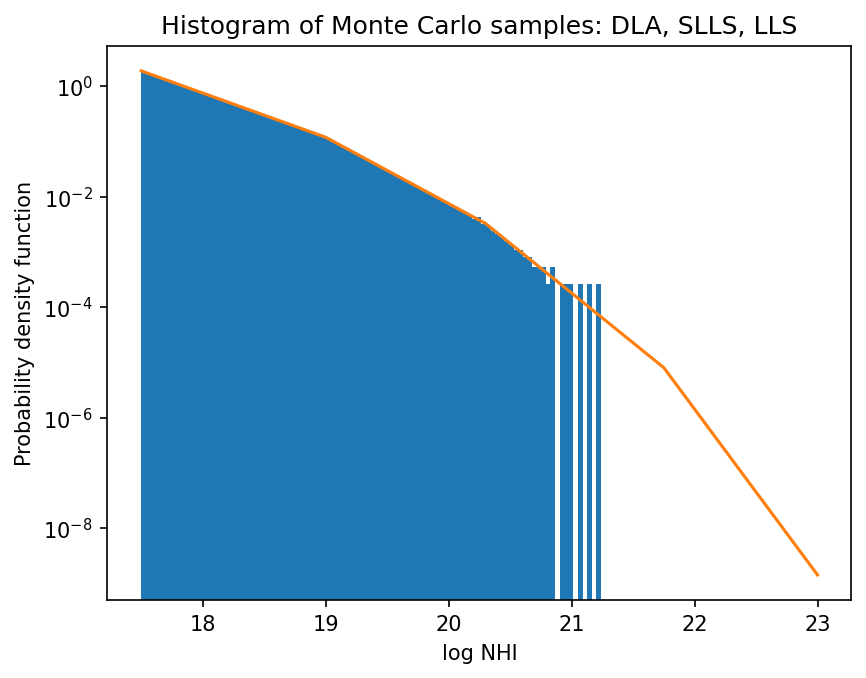

In [13]:
# double check the histogram
plt.hist(samples, bins=100, density=True)
plt.semilogy(log_nhis, normalized_pdf(log_nhis))
plt.title("Histogram of Monte Carlo samples: DLA, SLLS, LLS")
plt.xlabel("log NHI")
plt.ylabel("Probability density function")

## Sampling for MgII


Text(0, 0.5, 'Probability density function')

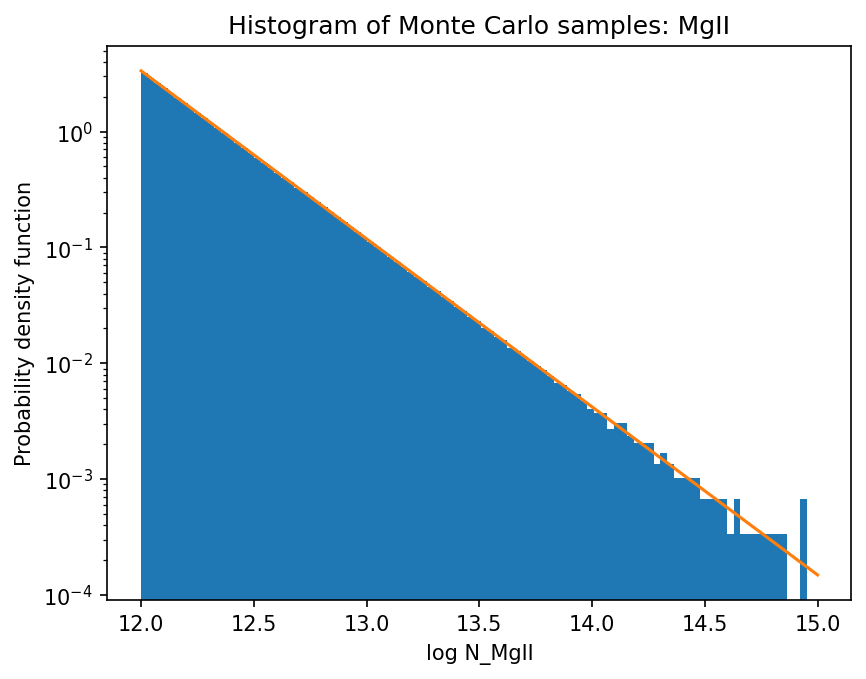

In [14]:
# CDDF for MgII
unnormalized_pdf = lambda log_nmgii: 10 ** log_cddf_mgii(log_nmgii)

Z = quad(unnormalized_pdf, 12, 15)[0]

normalized_pdf = lambda log_nmgii: unnormalized_pdf(log_nmgii) / Z

# Do the inverse transform sampling
samples_mgii = inverse_transform_sampling(normalized_pdf, (12, 15), sampler, 100000)

# double check the histogram
plt.hist(samples_mgii, bins=100, density=True)
plt.semilogy(log_ns, normalized_pdf(log_ns))
plt.title("Histogram of Monte Carlo samples: MgII")
plt.xlabel("log N_MgII")
plt.ylabel("Probability density function")

Text(0, 0.5, 'Probability density function')

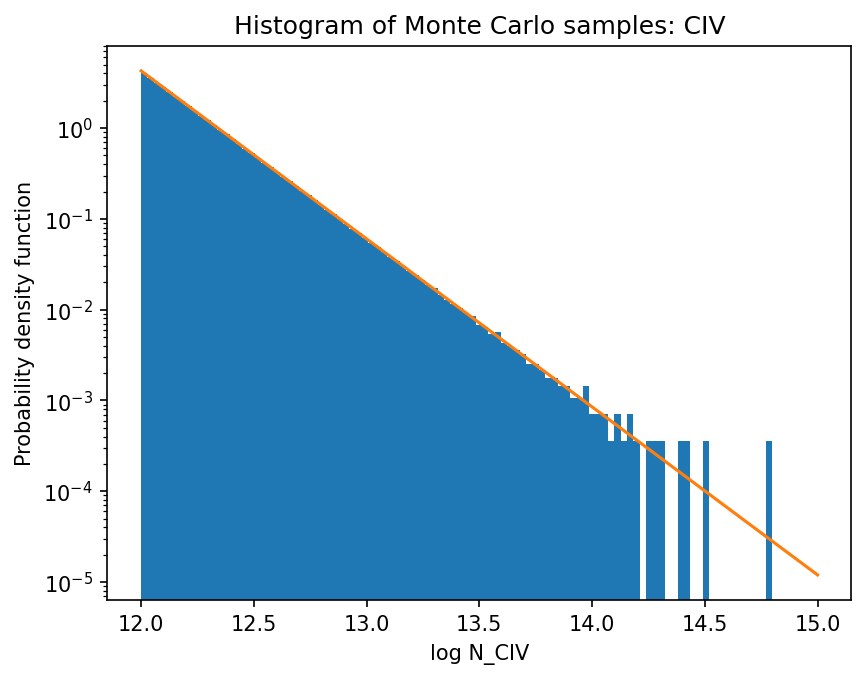

In [15]:
# CDDF for CIV
unnormalized_pdf = lambda log_nciv: 10 ** log_cddf_civ(log_nciv)

Z = quad(unnormalized_pdf, 12, 15)[0]

normalized_pdf = lambda log_nciv: unnormalized_pdf(log_nciv) / Z

# Do the inverse transform sampling
samples_civ = inverse_transform_sampling(normalized_pdf, (12, 15), sampler, 100000)

# double check the histogram
plt.hist(samples_civ, bins=100, density=True)
plt.semilogy(log_ns, normalized_pdf(log_ns))
plt.title("Histogram of Monte Carlo samples: CIV")
plt.xlabel("log N_CIV")
plt.ylabel("Probability density function")

In [16]:
import h5py

with h5py.File("data/dr12q/processed/hi_samples.h5", "r") as f:
    samples_log_nhis = f["samples_log_nhis"][()]

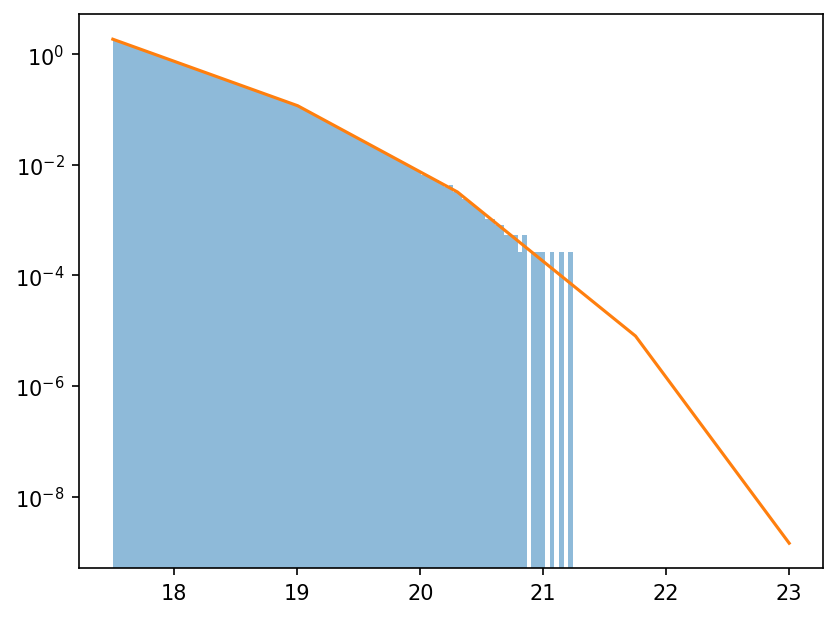

In [17]:
# Plot the histogram of the samples
plt.hist(samples_log_nhis, bins=100, density=True, alpha=0.5, label="DR12Q")
# Check with CDDF of DLA, SLLS, LLS
# directly CDDF for DLA, SLLS, LLS
unnormalized_pdf = lambda log_nhi: (
    10 ** log_cddf_lls(log_nhi) * (log_nhi < 19) * (log_nhi >= 17.5)
    + 10 ** log_cddf_slls(log_nhi) * (log_nhi >= 19) * (log_nhi < 20.3)
    + 10 ** log_cddf_dla(log_nhi, -1.8) * (log_nhi < 21.75) * (log_nhi >= 20.3)
    + 10 ** log_cddf_dla(log_nhi, -3) * (log_nhi >= 21.75)
)

Z = quad(unnormalized_pdf, 17.5, 23.0)[0]

normalized_pdf = lambda log_nhi: unnormalized_pdf(log_nhi) / Z

plt.semilogy(log_nhis, normalized_pdf(log_nhis), label="CDDF")